In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read();return HTML(styles)
css_styling()


<figure>
<IMG SRC="./images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>

# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Week 8: Sampling Theorem and interpolation

<figure>
<IMG SRC="http://upload.wikimedia.org/wikipedia/commons/d/d5/AliasedSpectrum.png" WIDTH=220 ALIGN="right" STYLE="padding-left:20px" ALT="http://en.wikipedia.org/wiki/Nyquist–Shannon_sampling_theorem">
</figure>

We have not talked yet about the process of digitizing our data, though we have assumed it for all the computer examples so far.  Digitization is usually carried out using an **analog-to-digital converter** on a **preconditioned** signal.  You may have encountered ADCs in your electronics class, and we won't discuss how they work here.  Preconditioning of the signal, however, is important to achieve a good representation of the signal because of **aliasing** of high frequencies can contaminate the signals we are interested in.  The typical preconditioning step is to apply a low-pass filter to the data and then sampling fast enough to capture the filtered signal.  Modern applications actually have very fast ADCs (GHz), that are then digitally filtered to return low-passed signals which are subsequently decimated for storage.    

We also need to consider what happens when there are gaps in our time series, which can happen due to instrument failure, changing instruments etc.  The approaches for this are probably review for most of you, and include **linear interpoloation**, **nearest-neighbour interpolation**, and **cubic-spline interpolation**.  


## Sampling Theorem

The sampling theorem states that a continuous signal with limited frequency bandwidth can be exactly represented as discrete time series with dense enough time sampling.  This means that the discretization is **lossless**, not just at the times of the discretization, but at all the times between.  

Formally, let $x(t)$ be our *continuous* time series.  If the *continuous* Fourier transform of $x(t)$ is $X(f)$, then $x(t)$ is **bandlimited** if $\left|X(f)\right|=0$ for $\left|f\right|>B$, for some frequency $B$, which we call the **band limit**.

Lets consider a signal that is white noise and has a peak at 31.5 Hz.  

/Users/jklymak/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


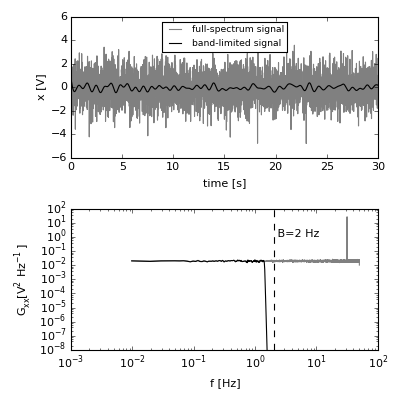

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import matplotlib.mlab as mlab
%matplotlib nbagg

N=1e6
dt = 1e-2
# make random noise. 
x0 = np.random.randn(N)
# add a 31.5 Hz signal to x
t = np.arange(0,N*dt,dt)
x0 = x0+1.*np.cos(t*2*np.pi*31.5)
#Bandwidth = 2 Hz
B=2.
# filter to make Bandlimited signal
fp=B*0.7
fs = B*0.9
fNyq=1/2./dt
n,fn=signal.ellipord(fp/fNyq, fs/fNyq,.1, 60.)
b,a=signal.ellip(n,.1,60.,fn)
xBL = signal.filtfilt(b,a,x0)
fig,ax=plt.subplots(2,1,figsize=(5,5))

ax[0].plot(t,x0,color='0.5',label='full-spectrum signal')
ax[0].plot(t,xBL,color='k',label='band-limited signal')
ax[0].set_xlim([0,30]);ax[0].set_xlabel('time [s]');ax[0].set_ylabel('x [V]');ax[0].legend(fontsize='small',loc=0)

nfft=10240
pxx,f=mlab.psd(x0,NFFT=nfft,Fs=1./dt,noverlap=nfft/2.,window=mlab.window_hanning)
pxBL,f=mlab.psd(xBL,NFFT=nfft,Fs=1./dt,noverlap=nfft/2.,window=mlab.window_hanning)
ax[1].loglog(f,pxx,color='0.5')
ax[1].loglog(f,pxBL,color='k')
plt.axvline(x=B,linestyle='--',color='k');ax[1].text(B,1,' B=2 Hz');ax[1].set_ylim([1e-8,1e2]);ax[1].set_xlabel('f [Hz]');ax[1].set_ylabel('$G_{xx} [V^2 Hz^{-1}]$')
plt.tight_layout()

Here, for display purposes we have approximated a continuous signal with a signal that has a sampling frequency of 100 Hz (I can't plot a continuous signal!).  Two signals are shown, one that is not bandlimited (to 50 Hz, anyways), and a second that is bandlimited at $B=2\ Hz$.  

The point of the sampling theorem is that you would need to sample at about 4 Hz to capture *all* of the bandlimited signal, whereas you could not capture all of the full-sepctrum signal.  Intuitively, that hopefully makes sense:

<IPython.core.display.Javascript object>


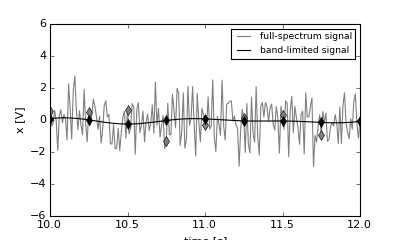

In [5]:
fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.plot(t,x0,color='0.5',label='full-spectrum signal');ax.plot(t,xBL,color='k',label='band-limited signal')
ax.plot(t[::25],x0[::25],'d',color='0.5')
ax.plot(t[::25],xBL[::25],'d',color='k')
ax.set_xlim([10,12]);ax.set_xlabel('time [s]');ax.set_ylabel('x [V]');ax.legend(fontsize='small',loc=0)

The grey diamonds do not begin to capture the variability of the grey line, whereas the black diamonds seem to do a reasonable job of the variability of the black line.

#### Sampling Theorem#### 
States that if $x(t)$ is a bandlimited signal such that $\left|X(f)\right|=0$ for $\left| f\right|>B$, then $x(t)$ can be represented in full by a discrete time series $x_n$ sampled every $\Delta t$ if $\frac{1}{\Delta t} \geq 2B$, and in particular we can reconstruct $x(t)$ as:

$$x(t) = \sum_{n=-\infty}^{\infty} x(n\Delta t) \frac{\sin \left(\pi \left( \frac{t}{\Delta t}- n\right) \right)}{\pi\left(\frac{t}{\Delta t}-n\right)}$$

#### Proof####

The proof is relatively straight forward.  We note that because $X(f)$ is zero for $\left| f\right| >B$ then it can be expanded as a discrete Fourier series:

$$ X(f) = \sum_{n=-\infty}^{\infty} c_n \mathrm{e}^{-j\frac{ 2\pi f n}{B}}$$

where $c_n$ is given by

\begin{align}
    c_n =& \frac{1}{2B} \int_{-B}^B X(f)\ \mathrm{e}^{+j2\pi f\frac{ n }{2B}}\ \mathrm{d}f\\
    =& \frac{1}{2B}x\left(n/2B\right)
\end{align}

So, this gives us the ingredients for $x(t)$:

\begin{align}
  x(t) &= \int_{-\infty}^{\infty} X(f) \mathrm{e}^{j2\pi f t}\ \mathrm{d}f\\
  & = \frac{1}{2B} \int_{-B}^{B} \mathrm{e}^{j2\pi f t}\ \sum_{n=-\infty}^{\infty} x(n/2B) \mathrm{e}^{-j\frac{2\pi f n}{B}} \mathrm{d}f\\
  & = \sum_{n=-\infty}^{\infty} x_n \int_{-B}^B \mathrm{e}^{j2\pi f \left(t-n/2B\right)}\ \mathrm{d}f\\
  & = \sum_{n=-\infty}^{\infty} x_n \frac{\sin \left(\pi \left(2Bt -n \right) \right)}{\pi \left(2Bt-n\right)}
\end{align}

where whe have defined $x_n = x(n/2B) = x(n\Delta t)$, and $\Delta t = 1/2B$ is the sample spacing. 

Note that for $t=n/2B$, $x(t)=x_n$.  For times in between the sample points, $t\neq n/2B$, we need an infinite sum of all the other points in the discrete time series to recover the true value at $x(t)$.  

Of course a limitation of real data is that we do not have infinite data, so any estimate at $t\neq n/2B$ is going to be slightly imprecise.  However, the sinc function rolls off quite quickly, so in practice this is not too much of a problem.  Lets consider this using the example above.  Here we subsample the bandlimitted time series by a factor of 25 and compare the reconstruction to the original time series.

<IPython.core.display.Javascript object>


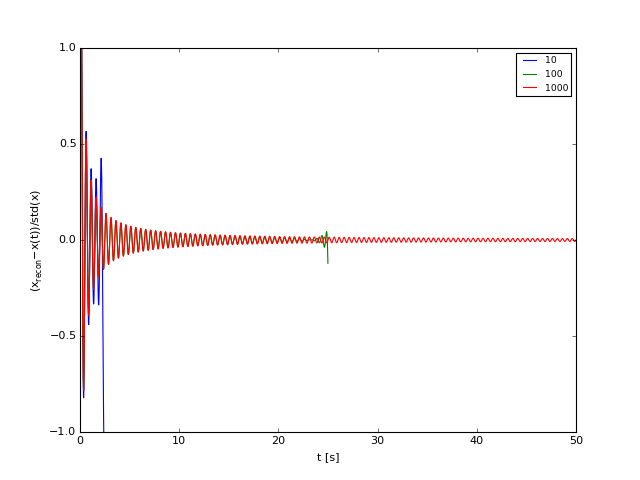

In [8]:
# decimated time series:
tn = t[::25]
xn = xBL[::25]
Ns = [10,100,1000]
fig,ax=plt.subplots(1,1)
for N in Ns:
    n = np.arange(N)
    # reconstruct the full time series just from the subsampled data xn:  
    xreco=1.*xBL[:N*25] # trim the last N*25 data points...
    for i in range(N*25):
        xreco[i] = np.sum(xn[:N]*np.sinc(2*B*t[i]-n))
    ax.plot(t[:N*25],(xreco-xBL[:N*25])/np.std(xBL),label='%d'%N)
    plt.xlim([0,50])
plt.xlabel('t [s]')
plt.ylabel('$(x_{recon}-x(t))/std(x)$')
plt.ylim([-1.,1.])
plt.legend(fontsize='small')
    

So here we see the effect of having only a finite number of samples to reconstruct your data from; there is a bad edge effect (because you do not have the data from the negaitve side of the infinite sum), and then improvement in the estimate towards the center of the sample.  Obviously the more data you have and the more away from the edges of the time series you are the better the approximation.  

## Aliasing

An important flipside to the Sampling Theorem is that if you *do* have significant energy at frequencies greater than $f_S$, your sampling frequency, then your subsampled signal will contain that variance, but **aliased** to one of the resolved frequencies.  This can be a huge problem:

<IPython.core.display.Javascript object>


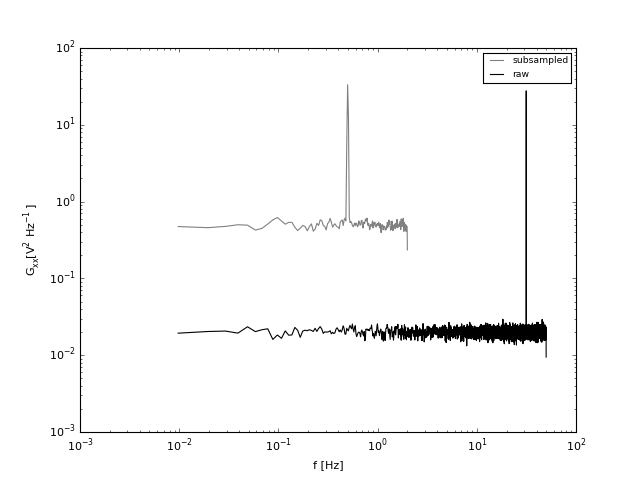

Variance of subsampled: 1.485
Variance of raw: 1.498


In [10]:
xl=x0 # +np.cos(2*pi*7.001*t)
xna = xl[::25]
tna = t[::25]
pxna,fn2=mlab.psd(xna,Fs=1/dt/25,NFFT=nfft/25)
pxnB,fn=mlab.psd(xl,Fs=1/dt,NFFT=nfft)
fig,ax=plt.subplots(1,1)
ax.loglog(fn2,pxna,color='0.5',label='subsampled')
ax.loglog(fn,pxnB,color='k',label='raw')
ax.legend(fontsize='small',loc=0)
ax.set_xlabel('f [Hz]')
ax.set_ylabel('$G_{xx} [V^2 Hz^{-1}]$')
print 'Variance of subsampled: %1.3f'%np.var(xna)
print 'Variance of raw: %1.3f'% np.var(xl)

So we can see that the peak at 31.5 Hz is aliased back to about 0.1 Hz! Perhaps even worse, the high freqeuncy variance ahove 2 Hz is all wrapped back to the low frequencies.  This shouldn't be surprising in light of Parseval's theorem - the integral under the two curves is the variance of the signal, and subsampling does not reduce the variance.   

So, if we have variance at a frequency $f>f_{Nyq}$ where does it get aliased to?  We can consider a frequency for the signal $f_0$ and determine its modulus with the Nyquist frequency:

$$f_0=mf_{Nyq} + \delta f$$

then

\begin{align}
\cos\left( 2\pi f_0 t_n\right) &= \cos\left( 2\pi f_0 n\Delta t\right)\\
    &= \cos\left( 2\pi m f_{Nyq} n\Delta t + 2\pi \delta f \Delta t \right)\\
     &= \cos\left( \pi m n + 2\pi \delta f \Delta t \right)\\
     &= \begin{cases}
     \cos\left(2\pi \delta f n \Delta t\right) & m\ \text{even}\\
     \cos\left(\frac{2\pi m n \Delta t}{2\Delta t}+  \delta f n \Delta t\right) & m\ \text{odd}\\
     \end{cases}\\
     &= \begin{cases}
     \cos\left(2\pi \delta f  \Delta t\right) & m\ \text{even}\\
     \cos\left(\frac{2\pi  n \Delta t}{2\Delta t}+  \delta f n \Delta t\right) & m\ \text{odd}\\
     \end{cases}\\
      &= \begin{cases}
     \cos\left(2\pi t_n \delta f \right) & m\ \text{even}\\
     \cos\left(2\pi  t_n \left(f_N-\delta f \right)\right)  & m\ \text{odd}\\
     \end{cases}
\end{align}

so the aliased frequency, $f_A$, is given by

$$f_A =\begin{cases}
     \delta f & m\ \text{even}\\
     f_N-\delta f & m\ \text{odd}\\
\end{cases}
$$

So, for the case above, the spike at $f_0=31.5 Hz$ and a Nyquist frequency of $f_{Nyq}=2 Hz$, $m=15$, and $\delta f=1.5 Hz$, so $f_A=2-1.5\ Hz=0.5\ Hz$.  


Note that we can get a bit confused if $f_0=mf_{Nyq}$ because $\delta f=0 Hz$ so $f_A=0$ or $f_A = f_{Nyq}$, therefore the mean or the highest frequency is affected, not the interior of the spectrum.  

### Preconditioning

The solution to aliasing in practical applications is to make sure you apply an **anti-aliasing filter** to the analog signal before digitizing it.  This is just a low-pass filter with its cut-off frequency significantly lower than the Nyquist frequency.  This is typical in ADC's.  

## Dealing with data gaps: Interpolation

We have seen in the weather data time series that there are freqeunt data gaps.  We have been ignoring them, but that actually introduces phase distortion to your time series as you are removing data.  Typically it is better to interpolate over the bad data.  

It also happens sometimes that data is not collected at regular time (or space) intervals.  For instance, some manual intervention is needed, and a technician runs the data when they can.  

There are different methods to interpolate, which you are probably familair with:

### Nearest Neighbour Interpolation

This relatively trivial: If we have data $x_i$ collected at times $t_i$, where $t_i$ are not necessarily evenly spaced, then $x(t)=x_j$, for the $j$ where $|t-t_j|$ is the minimum over all $j$.  This makes stair-stepped data and will have discontinuities between data points.

First, lets set up an example.  `x` is our signal, which is then sampled at times `t2` to make `x2`

<IPython.core.display.Javascript object>


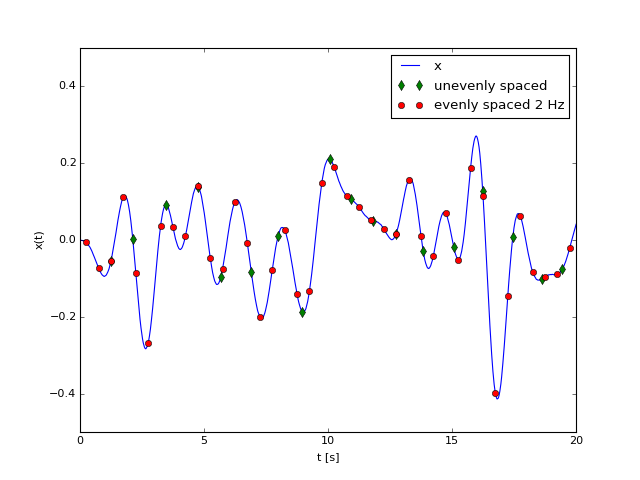

In [37]:
import scipy.signal as signal
np.random.seed(1345)
N = 100000
T = 1000. # s.
t = np.arange(0,T,T/N)
fN = N/T/2.
b,a=signal.ellip(5,0.5,60.,0.75/fN)
x = signal.lfilter(b,a,(np.random.randn(N+1)))[:-1]

dt = np.random.rand(N)*0.75+0.75
t2 = np.cumsum(dt)
t2 = t2[t2<t[-1]]
x2 = np.interp(t2,t,x)
# t2 is unevenly spaced 

y = x[range(25,N,50)]
ty = t[range(25,N,50)]
#y is evenly spaced at 2 Hz. 

ygap=1.*y
tygap=1.*ty
ygap=np.delete(ygap,np.arange(30,60))
tygap=np.delete(tygap,np.arange(30,60))

fig,ax=plt.subplots()
ax.plot(t,x)
ax.plot(t2,x2,'d')
ax.plot(ty,y,'o')
ax.set_xlim((0,20)); ax.set_ylabel('x(t)');ax.set_xlabel('t [s]')
ax.legend(('x','unevenly spaced','evenly spaced 2 Hz'))

Here $x$ is a band-limited time series that we then downsample to 2 Hz (red dots).  This is what we would like to retrieve.  Now imagine we had only collected data at the green dots.  Then we need to interpolate to the even 2-Hz time series.

<IPython.core.display.Javascript object>


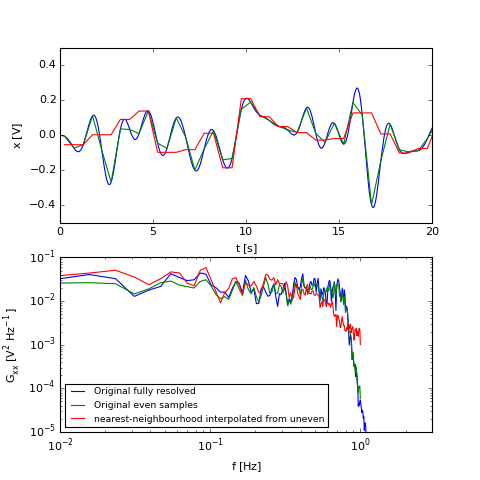

In [38]:
yi=0.*ty
for n in range(0,np.shape(ty)[0]):
    ind=np.argmin(abs(ty[n]-t2))
    yi[n]=x2[ind]
nfft=64*4
Gyy,f = mlab.psd(y,nfft,Fs=2,window=mlab.window_hanning,noverlap=nfft/2)
Gyiy,f = mlab.psd(yi,nfft,Fs=2,window=mlab.window_hanning,noverlap=nfft/2)
Gxx,f0 = mlab.psd(x,nfft*50,Fs=100,window=mlab.window_hanning,noverlap=nfft/2)
Gneigh=Gyiy
fig,ax=plt.subplots(2,1,figsize=(6,6))
ax[0].plot(t,x,label='Orig')
ax[0].plot(ty,y,label='Ideal Interp')
ax[0].plot(ty,yi,label='Nearest')
ax[0].set_xlabel(r'$t \ \mathrm{[s]}$')
ax[0].set_ylabel(r'$x\ \mathrm{[V]}$')
ax[0].set_xlim((0,20))

ax[1].loglog(f0,Gxx,f,Gyy,f,Gyiy)
plt.xlim((1e-2,3.))
plt.ylim((1e-5,1e-1))
plt.xlabel(r'$f\ \mathrm{[Hz]}$');
plt.ylabel(r'$G_{xx} \ \mathrm{[V^2 Hz^{-1}]}$')
ax[1].legend(('Original fully resolved','Original even samples','nearest-neighbourhood interpolated from uneven'),loc=3,fontsize='small')

So, nearest-neighbour is not too bad in this case until the very highest frequencies where there is some error.  Of course, the level of error depends on how far apart the data is in the uneven time series.

### Linear interpolation

Linear interpolation is simply interpolating onto a line formed by the two data points bracketing the time you are interested in getting a value at.  So if you want to know the value of $x(t)$ where $t_j<t<t_{j+1}$, then 

$$ x(t) = x_j+\left(t-t_j\right)\frac{x_{j+1}-x_j}{t_{j+1}-t_j}$$

<IPython.core.display.Javascript object>


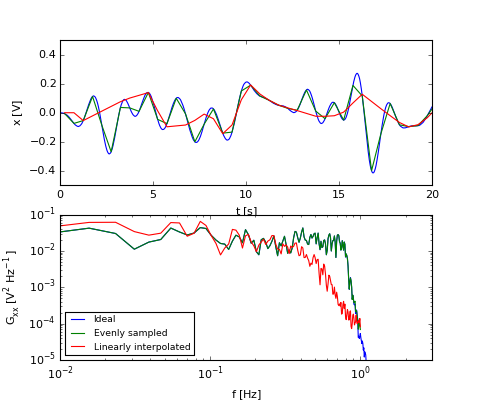

In [47]:
yi=0.*ty
for n in range(0,np.shape(ty)[0]):
    if (ty[n]>t2[0]) & (ty[n]<t2[-1]):
        ind=np.where(t2<ty[n])[0][-1]
        yi[n]=x2[ind]+(ty[n]-t2[ind])*(x2[ind+1]-x2[ind])/(t2[ind+1]-t2[ind])
    
#yi=interp(ty,t2,x2)
nfft=64*4
Gyy,f = mlab.psd(y,nfft,Fs=2)
Gyiy,f = mlab.psd(yi,nfft,Fs=2)
Gxx,f0 = mlab.psd(x,nfft*50,Fs=100)
Gneigh=Gyiy
fig,ax=plt.subplots(2,1,figsize=(6,5))
ax[0].plot(t,x,label='Orig')
ax[0].plot(ty,y,label='Ideal Interp')
ax[0].plot(ty,yi,label='Nearest')
ax[0].set_xlabel(r'$t \ \mathrm{[s]}$')
ax[0].set_ylabel(r'$x\ \mathrm{[V]}$')
ax[0].set_xlim((0,20))

ax[1].loglog(f0,Gxx,label='Ideal')
ax[1].loglog(f,Gyy,label='Evenly sampled')
ax[1].loglog(f,Gyiy,label='Linearly interpolated')
plt.xlim((1e-2,3.))
plt.ylim((1e-5,1e-1))
plt.xlabel(r'$f\ \mathrm{[Hz]}$');
plt.ylabel(r'$G_{xx} \ \mathrm{[V^2 Hz^{-1}]}$')
ax[1].legend(loc=3,fontsize='small')

This has less of a bias at low frequencies than the nearest-neighbour method.  It has some roll off at high frequencies which is not too surprising given that a straightline has as little variance as possible and the data gaps cause us to lose variance.

Note that the code above has checks to make sure we are not off the ends of the time series.  This is **extrapolation**, and should be dealt with carefully.  There are a couple of common choices for what to do with if we want to extrapolate: 
  
  1. Linearly extrapolate: i.e.  $x(t) = x_0+\left(t-t_0\right)\frac{x_{1}-x_0}{t_{1}-t_0}$.
  2. Nearest neighbour: $x(t)=x_0$.
  
Obviously, the further out you extrapolate, the worse the extrapolation.  Hopefully it doesn't change your signal, and is usually a bad idea in most situations.

### Cubic Spline Interpolation

Linear interpolation makes the data be continuous in time between the data points. Cubic spline takes this one step further and fits a cubic spline to keep the first and second derivatives continuous at the data points.  This requires a universal fit, since the derivatives depend on the data non-locally.  

So suppose, we have $N+1$ data points, $n=0,1,..N$, then we have $N$ segments between the data points, $i=0,1,...,N-1$.  We want the fit $q(t)$ to go through the data and for the derivatives to be continuous at the data points.  Let $q_i(t)$ be the fit between $t_i$ and $t_{i+1}$:

$$q_i(t)=a_i + b_i(t-t_i)+c_i(t-t_i)^2+d_i(t-t_i)^3.$$  

We need to fit the $4N$ constants to complete the spline fit.  To do this we choose matching conditions at the boundaries of the fit:

\begin{align}
    q_i(t_i)&=x_i \ \ \ \ \ \ \text{for}\ i=0...N-1\\
    q_i(t_{i+1})&=x_{i+1}\ \ \ \ \text{for}\ i=0...N-1\\
    q_i'(t_{i+1})&=q_{i+1}'(t_{i+1})\ \ \ \ \text{for}\ i=0...N-2\\
    q_i''(t_{i+1})&=q_{i+1}''(t_{i+1})\ \ \ \ \text{for}\ i=0...N-2\\
\end{align}

This is $4N-2$ equations, and $q_0(t)$ and $q_{N-1}(t)$ require two boundary conditions.  Different choices are possible, but a simple one is to set the second derivative to zero:

\begin{align}
    q_0''(t_0)&=0\\
    q_{N-1}''(t_{N})&=0\\
\end{align}

We can easily eliminate $N$ equations, because the first condition means that $a_i=x_i$ for $i=0,...,N-1$.  Defining $\Delta_i = t_{i+1}-t_i$ and solving for the other conditions gives:

\begin{align}
    x_i +\Delta_ib_i +\Delta_i^2c_i + \Delta_i^3d_i&=x_{i+1} \ \ \ \ \ \ \text{for}\ i=0...N-1\\
    b_i+2\Delta_ic_i+3\Delta_i^2d_i &=b_{i+1}\ \ \ \ \text{for}\ i=0...N-2\\
    2c_i+6d_i\Delta_i&=2c_{i+1}\ \ \ \ \text{for}\ i=0...N-2\\
    c_0&=0\\
    2c_{N-1}+6d_{N-1}\Delta_{N-1}&=0
\end{align}

With some patience we can eliminate $b_i$ and $d_i$ and get:

$$ \Delta_i c_i + 2 (\Delta_i+\Delta_{i+1})c_{i+1}+\Delta_{i+1}c_{i+2}=3\left[\frac{x_{i+2}-x_{i+1}}{\Delta_{i+1}} - \frac{x_{i+1}-x_{i}}{\Delta_i}\right] \ \ \ \ \text{for}\ i=0,...,N-2$$

and $c_N=c_0=0$ giving us $N+1$ equations. Note that we need the $N+1$ equations because there is a $c_{i+2}$ term in the equation above.

\begin{equation}
\begin{pmatrix}
    1 & 0 & 0 & \cdots & \cdots & \cdots & \cdots\\
    \Delta_0 & 2\left(\Delta_0+\Delta_1\right) & \Delta_1 & \cdots & \cdots & \cdots & \cdots\\
    \cdots & \cdots & \ddots & \cdots & \cdots & \cdots & \cdots\\
    \cdots & \cdots & \cdots  & \Delta_{N-3} & 2\left(\Delta_{N-3}+\Delta_{N-2} \right) & \Delta_{N-2} & 0\\
    \cdots & \cdots & \cdots &\cdots & \Delta_{N-2} & 2\left(\Delta_{N-2}+\Delta_{N-1} \right) & \Delta_{N-1}\\
    \cdots & \cdots & \cdots & \cdots & \cdots & 0 & 1
\end{pmatrix}
\begin{pmatrix}
    c_0\\
    c_1\\
    c_2\\
    \vdots\\
    c_{N-2}\\
    c_{N-1}\\
    c_{N}
\end{pmatrix}
= 3\begin{pmatrix}
    0\\
    \frac{dx_1}{\Delta_1}-    \frac{dx_0}{\Delta_0}\\
    \frac{dx_2}{\Delta_2}-    \frac{dx_1}{\Delta_1}\\
    \vdots\\
    \frac{dx_{N-1}}{\Delta_{N-1}}-    \frac{dx_{N-2}}{\Delta_{N-2}}\\   
    0
\end{pmatrix}
\end{equation}

This an $(N+1) \times (N+1)$ matrix, and solving for $c_i$ is theoretically easy, but computationally challenging if $N$ is large. Fortunately, it is also a sparse matrix (i.e. most of the entries are zero) and there are effcient techniques for solving these.  It is also possible to fit in chunks, and match boundary conditions across the chunks, which I believe is the algorithm usually used by packages.  

<IPython.core.display.Javascript object>


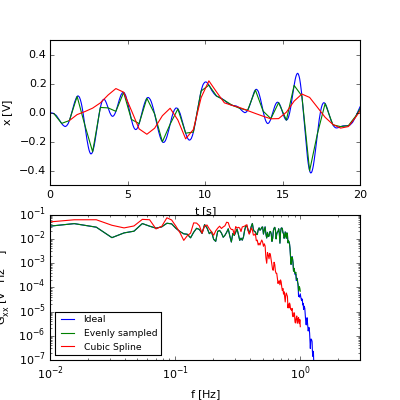

In [52]:
from scipy.interpolate import interp1d

ff=interp1d(t2,x2,kind='cubic')
tyn=ty[ty>t2[0]]

tyn=tyn[tyn<t2[-1]]
yi=ff(tyn)

Gyy,f = mlab.psd(y,nfft,Fs=2)
Gyiy,f = mlab.psd(yi,nfft,Fs=2)
Gxx,f0 = mlab.psd(x,nfft*50,Fs=100)
Gneigh=Gyiy
fig,ax=plt.subplots(2,1,figsize=(5,5))
ax[0].plot(t,x,label='Orig')
ax[0].plot(ty,y,label='Ideal Interp')
ax[0].plot(tyn,yi,label='Nearest')
ax[0].set_xlabel(r'$t \ \mathrm{[s]}$')
ax[0].set_ylabel(r'$x\ \mathrm{[V]}$')
ax[0].set_xlim((0,20))

ax[1].loglog(f0,Gxx,label='Ideal')
ax[1].loglog(f,Gyy,label='Evenly sampled')
ax[1].loglog(f,Gyiy,label='Cubic Spline')
plt.xlim((1e-2,3.))
plt.ylim((1e-7,1e-1))
plt.xlabel(r'$f\ \mathrm{[Hz]}$');
plt.ylabel(r'$G_{xx} \ \mathrm{[V^2 Hz^{-1}]}$')
ax[1].legend(loc=3,fontsize='small')

Here we see that the cubic spline does quite well at this type of signal.  

### Which interpolation to use?

I usually just use linear interpolation, largely because it will behave in a predictable way.  Cubic splines have have difficulty with noisy data, or data that has discontinuity.  However, the best advice is to try both linear and cubic spline and see which has the best response for the data you are trying to interpolate.